
#### Comparing Matrix Profile Model (new approach) to existing anomaly models

References
* https://www.cs.umn.edu/research/technical_reports/view/09-004
* https://www.cs.ucr.edu/~eamonn/Matrix_Profile_Tutorial_Part1.pdf
* https://towardsdatascience.com/the-matrix-profile-e4a679269692


#### Conclusions and Discussions

*show images for all the datasets ran*

**The effect of window size** <br>
**The effect of z_nomalization**

**How do we want to present it to the user** <br>
Discord is detected on a window of data

**Top k discords** <br>
Determines the number of anomaly we will detect for data <br>
This can be a user input


**Exclusion zone when detecting anomalies** <br>
Exclusion zone eliminates a window of entries around already founds discords when finding the next discord <br>
This is helps eliminate all the subsequence that include the anomaly caising the discord <br>
For this investigation, exclusionzone= +/- window_size, which is the size of the subsequence

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from src.comparingmodels import (utils, data, models)

import logging
from iotfunctions.enginelog import EngineLogging
EngineLogging.configure_console_logging(logging.INFO)

%load_ext autoreload
%autoreload 2
%matplotlib inline

/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/iotfunctions/bif.py:1884: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'


#### STEPS TO ANALYZE ANOMALY MODELS FOR A GIVEN DATASET <br>
For a given data run the following cells in order <br>

**1. Data Processing** describes the data we want to analyze<br>
**2. Running existing anomaly models** runs the models and summarizes all the anomaly scores calculated from existing model<br>
**3. Visualizing the result** plots the anomaly scores calculated above<br>
**4. Matrix Profile - Anomaly Detection** calculates the matrix profile and plots the anomaly score derived from it<br>


## Select data by uncommenting the corresponding line

In [2]:
datapath='../data/AzureAnomalysample.csv'; columnname='Temperature'; entity='MyRoom'; datasel=columnname
#datapath='../data/Armstark04714B6046D5.csv'; columnname = 'vibrations'; entity='04714B6046D5'; datasel=columnname
#datapath='../data/Armstark04714B604101.csv'; columnname = 'vibrations'; entity='04714B604101'; datasel=columnname
#datapath='../data/Cakebread36_datalastweek.csv'; columnname = 'floatvalue'; entity='CakebreadId_0036'; datasel=columnname
#datapath='../data/Cakebreak128.csv'; columnname = 'floatvalue'; entity='CakebreadId_0128'; datasel=columnname
#datapath = '../data/Anomaly_Sample_data.csv'; columnname='TEMPERATURE'; entity='A101'; datasel='pressure'

**1. Data Processing**

In [3]:
#column we want to analyze
md = data.MonitorData(data_sel = datasel)
df_i = md.get_data(datapath=datapath)

df_i.describe()

,Temperature
count,4000.000000
mean,24.264336
std,1.484244
min,20.000000
25%,23.062500
50%,24.000000
75%,25.437500
max,30.750000


**2. Running existing anomaly models**

In [4]:
#Define ExistingModels with the column we want to run the scoring on
em = models.ExistingModels(columnname=columnname)
df_anomaly = em.run_all(df_i)
df_anomaly.describe()

2020-10-05T17:09:27.917 INFO iotfunctions.dbtables.__init__ Init FileModelStore
2020-10-05T17:09:31.425 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-10-05T17:09:31.652 INFO iotfunctions.dbtables.__init__ Init FileModelStore
2020-10-05T17:09:32.847 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
Saliency   Entity: MyRoom, result shape: (665,) score shape: (665,) input shape: (4000,)
2020-10-05T17:09:33.536 INFO iotfunctions.dbtables.__init__ Init FileModelStore
2020-10-05T17:09:34.821 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-10-05T17:09:38.213 INFO iotfunctions.dbtables.__init__ Init FileModelStore
2020-10-05T17:09:39.678 WARNING i

,Temperature,SpectralAnomalyScore,SaliencyAnomalyScore,KmeansAnomalyScore,FFTAnomalyScore
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,24.264336,7.936961,91.817724,0.723263,87.294243
std,1.484244,29.140010,558.489522,1.047700,335.367443
min,20.000000,0.048718,0.868042,0.005014,0.000000
25%,23.062500,3.809004,7.241030,0.379121,8.609340
50%,24.000000,4.482759,16.438002,0.476029,13.507883
75%,25.437500,5.051216,33.646194,0.580460,19.877555
max,30.750000,815.618754,10066.068084,7.524000,4407.188310


**3. Visualizing the result**

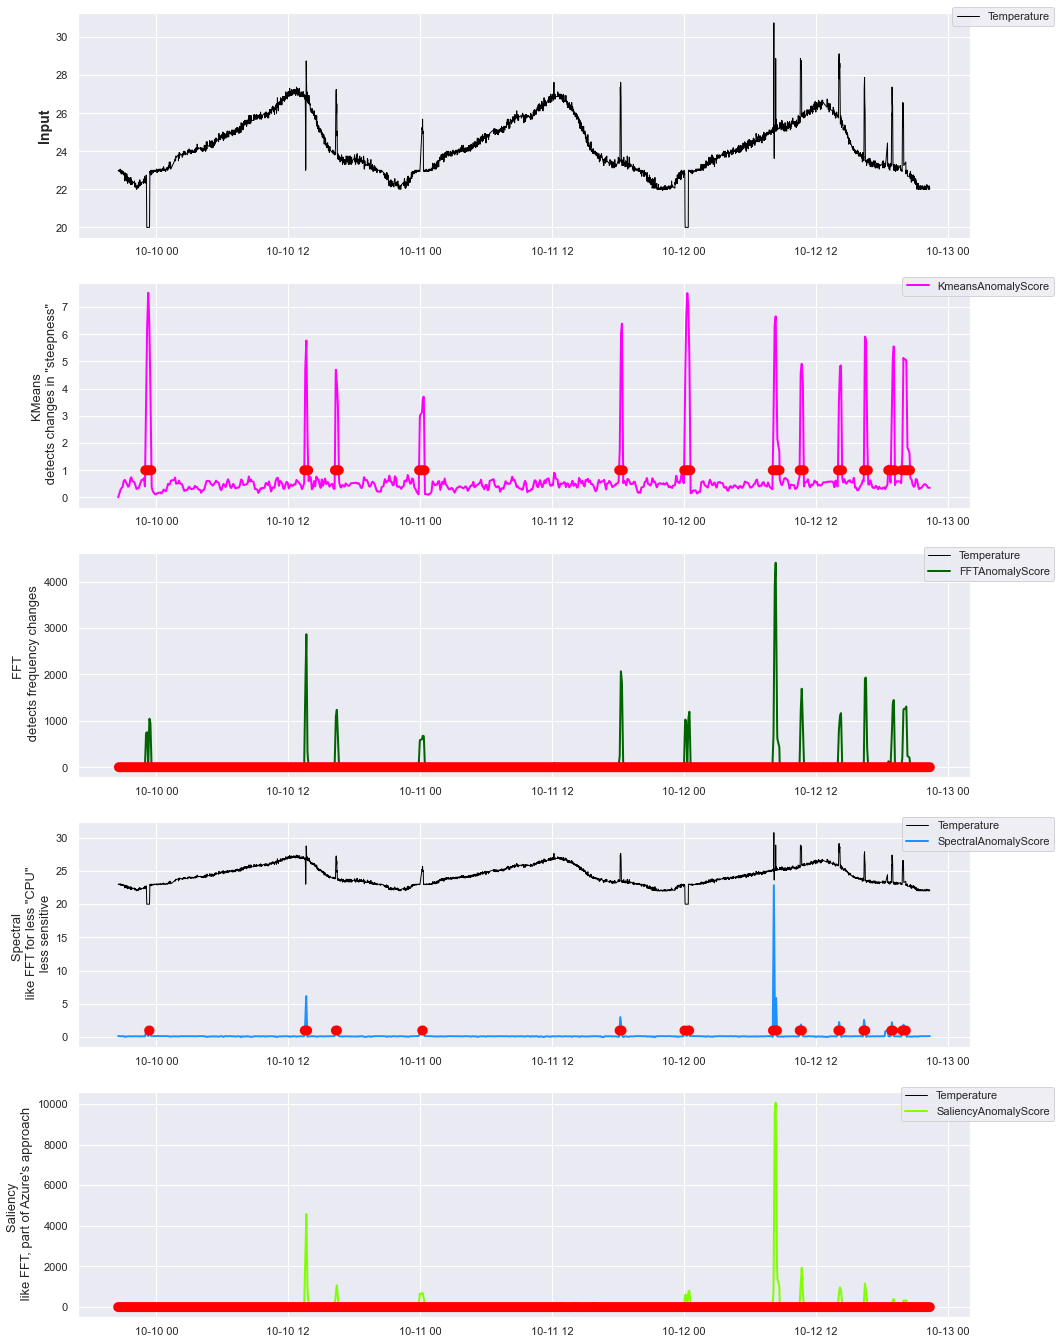

In [5]:
# Simplify dataframe to prepare input for plotting
df_plot = df_anomaly.loc[[entity]]
df_plot.reset_index(level=[0], inplace=True)
em.plot_all(df_plot)

***NEW MODEL*** <br>
**4. Matrix Profile - Anomaly Detection**

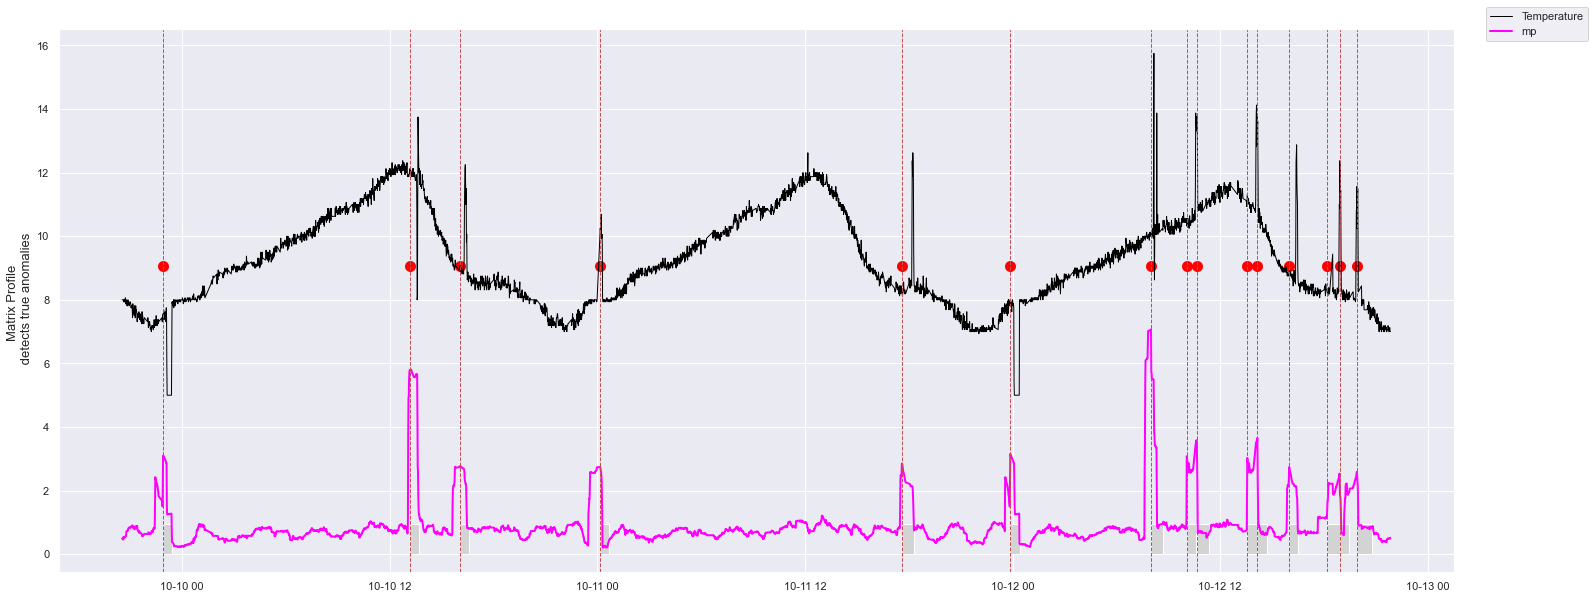

In [6]:
#Matrix Profile
window_size = 2**5
mp = models.MatrixProfile(df=df_i, columnname=columnname, windowsize=window_size,z_normalized=False)
mp.run_model()
df_ret = mp.plot_mp(threshold=15, columnsub=15, printdata=False, motif=False)